# **ESPLORAZIONE DATASET MAMMOGRAFIA**

## **Caratteristiche principali del MIAS Dataset**

1. Formato delle immagini:
    - Tutte le immagini sono state ridotte a una risoluzione di 1024x1024 pixel.
    - Ogni pixel rappresenta 200 micron (0,2 mm).
    - Le immagini sono in bianco e nero (grayscale).
2. Annotazioni disponibili (ground truth):
    - Ogni immagine può contenere un’anomalia o essere normale.
    - Sono fornite le coordinate (x, y) del centro dell’anomalia.
    - Una classe dell’anomalia:
        - CALC: Calcificazioni
        - CIRC: Masse ben definite
        - SPIC: Masse spiculate
        - MISC: Masse mal definite
        - ARCH: Distorsioni architettoniche
        - ASYM: Asimmetrie
        - NORM: Normale
    - Una etichetta di severità:
        - B: Benigno
        - M: Maligno
    - Un raggio approssimativo in pixel che definisce l’estensione della lesione.
3. Tessuto di fondo:
    - F: Fatty (grasso)
    - G: Fatty-glandular (grasso + ghiandolare)
    - D: Dense-glandular (denso ghiandolare)
4. Numero di immagini:
    - Circa 322 immagini, rappresentano 161 pazienti (immagini sinistra/destra in coppia).

## 1 Esplorazione del dataset

### 1.1 Distribuzione anomalie

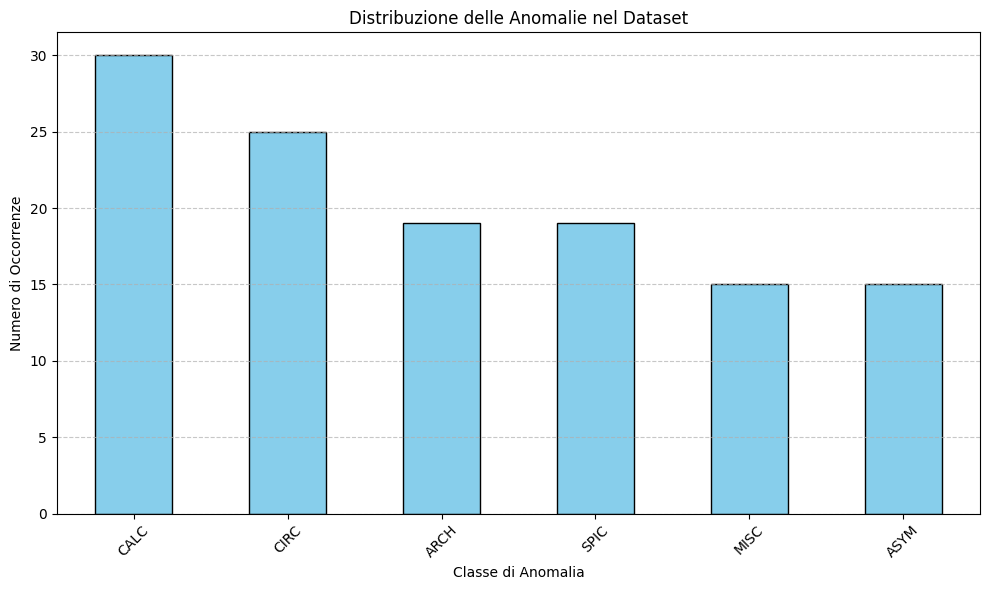

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il CSV
df = pd.read_csv('mammography_dataset.csv')

# Rimuove le righe senza anomalia (es. classe = NORM)
df_anomalies = df[df['Anomaly_Type'] != 'NORM']

# Conta la distribuzione delle classi di anomalia
anomaly_counts = df_anomalies['Anomaly_Type'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
anomaly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Anomalie nel Dataset')
plt.xlabel('Classe di Anomalia')
plt.ylabel('Numero di Occorrenze')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 1.2 Anomalie dalla radiografia

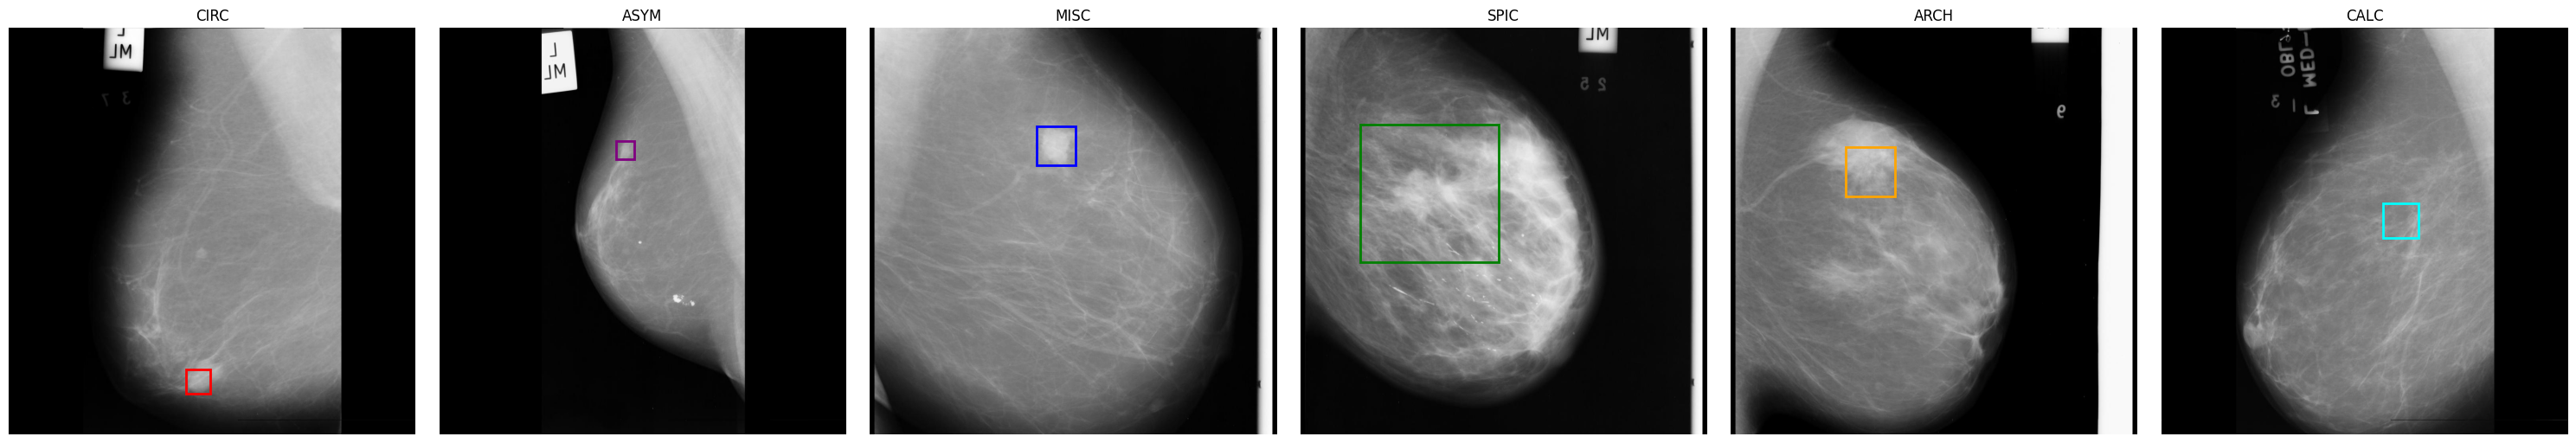

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image

# === Percorsi ===
csv_path = 'mammography_dataset.csv'
images_dir = 'MIAS-JPEG'  # <-- CAMBIA con il tuo path

# === Carica CSV ===
df = pd.read_csv(csv_path)

# Converte le colonne numeriche in float
df['X_Center'] = pd.to_numeric(df['X_Center'], errors='coerce')
df['Y_Center'] = pd.to_numeric(df['Y_Center'], errors='coerce')
df['Radius'] = pd.to_numeric(df['Radius'], errors='coerce')

# Filtra: solo anomalie, solo tessuto F, ed esclude righe con NaN
df = df[(df['Anomaly_Type'] != 'NORM') & 
        (df['Breast_Tissue'] == 'F') &
        df[['X_Center', 'Y_Center', 'Radius']].notnull().all(axis=1)]

# Trova una sola immagine per ogni tipo di anomalia
example_images = {}
for cls in df['Anomaly_Type'].unique():
    row = df[df['Anomaly_Type'] == cls].iloc[0]
    example_images[cls] = row

# === Setup plot ===
n = len(example_images)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))

if n == 1:
    axes = [axes]

# Colori diversi per tipo di anomalia (puoi personalizzarli)
colors = {
    'CIRC': 'red',
    'SPIC': 'green',
    'MISC': 'blue',
    'ARCH': 'orange',
    'ASYM': 'purple',
    'CALC': 'cyan'
}

# === Loop immagini ===
for ax, (cls, row) in zip(axes, example_images.items()):
    img_path = os.path.join(images_dir, row['Image_ID'] + '.jpg')
    if not os.path.exists(img_path):
        print(f"Immagine non trovata: {img_path}")
        continue

    img = Image.open(img_path).convert("L")

    ax.imshow(img, cmap='gray')
    ax.set_title(cls)
    ax.axis('off')

    x_center = float(row['X_Center'])
    y_center = float(row['Y_Center'])
    r = float(row['Radius'])

    # Converti y da origine bottom-left a origine top-left
    y_top_left = img.height - y_center

    # Calcola coordinate bounding box top-left
    x_min = x_center - r
    y_min = y_top_left - r

    # Disegna il rettangolo
    rect = patches.Rectangle((x_min, y_min), 2*r, 2*r,
                             linewidth=2,
                             edgecolor=colors.get(cls, 'yellow'),
                             facecolor='none')
    ax.add_patch(rect)

plt.tight_layout()
plt.show()


### 1.2.1 Distribuzione per gravità

C:\Users\smike18\AppData\Local\Temp\ipykernel_8012\2801400132.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Severity', palette='Set2')


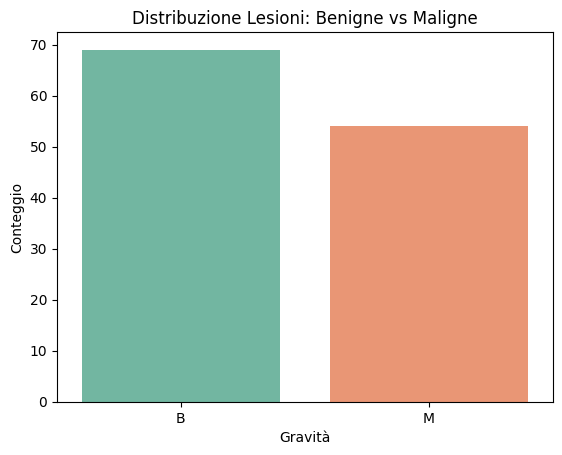

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='Severity', palette='Set2')
plt.title('Distribuzione Lesioni: Benigne vs Maligne')
plt.xlabel('Gravità')
plt.ylabel('Conteggio')
plt.show()


### 1.3.2  Associazione tra tipo di tessuto e tipo di anomalia

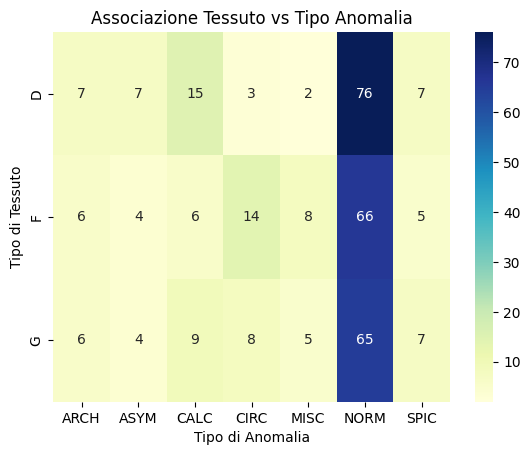

In [62]:
cross_tab = pd.crosstab(df['Breast_Tissue'], df['Anomaly_Type'])

sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Associazione Tessuto vs Tipo Anomalia')
plt.xlabel('Tipo di Anomalia')
plt.ylabel('Tipo di Tessuto')
plt.show()


### 1.3.3  Istogramma del raggio della lesione

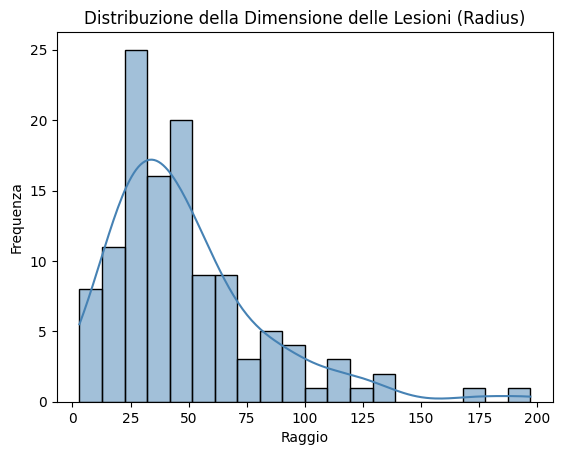

In [63]:
sns.histplot(data=df, x='Radius', bins=20, kde=True, color='steelblue')
plt.title('Distribuzione della Dimensione delle Lesioni (Radius)')
plt.xlabel('Raggio')
plt.ylabel('Frequenza')
plt.show()


### 1.3.4 Mappa di calore spaziale (coordinate della lesione)

C:\Users\smike18\AppData\Local\Temp\ipykernel_8012\1680856450.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


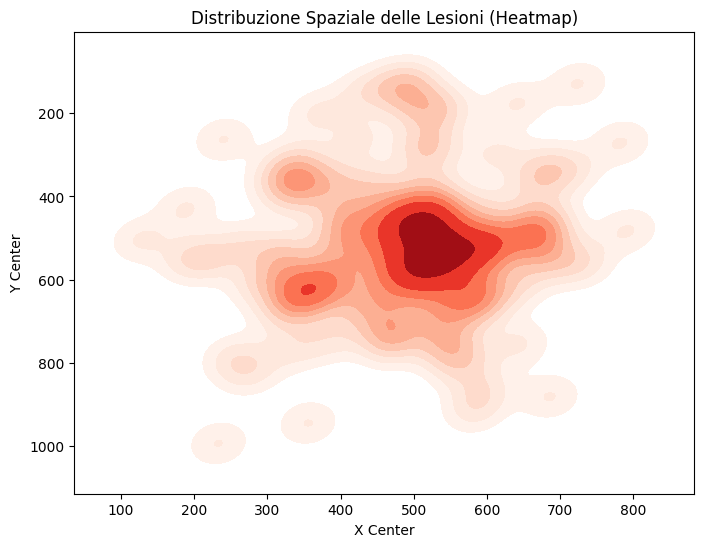

In [64]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    x=df['X_Center'], 
    y=df['Y_Center'], 
    cmap="Reds", 
    shade=True, 
    bw_adjust=0.5
)
plt.title('Distribuzione Spaziale delle Lesioni (Heatmap)')
plt.xlabel('X Center')
plt.ylabel('Y Center')
plt.gca().invert_yaxis()  # Le immagini spesso hanno l'origine in alto a sinistra
plt.show()


Nella heatmap spaziale (ottenuta dal kdeplot), la zona rossa rappresenta la regione in cui le anomalie si verificano più frequentemente nel dataset. È una visualizzazione della densità di lesioni basata sulle coordinate (X_Center, Y_Center) di tutte le immagini.

C:\Users\smike18\AppData\Local\Temp\ipykernel_8012\568674000.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


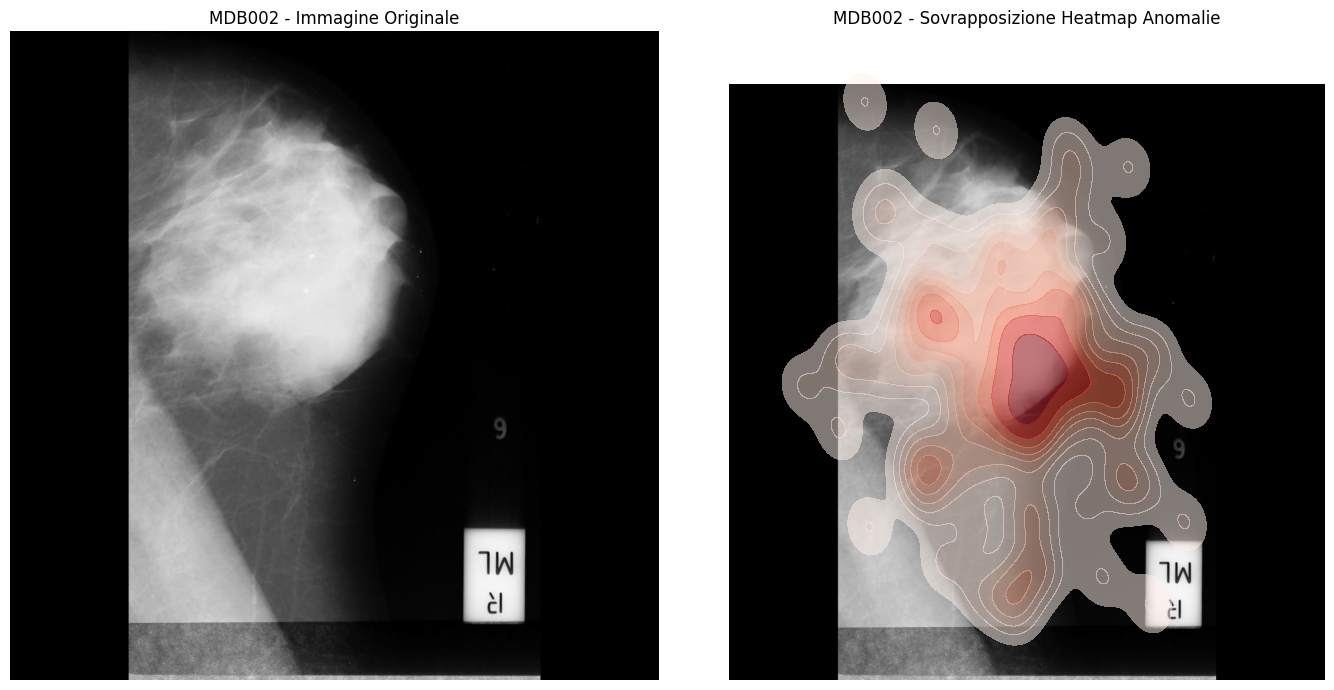

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image

# Carica i dati
df = pd.read_csv('mammography_dataset.csv')  # o il percorso che usi tu
img_id = 'mdb002'             # puoi cambiare con qualunque ID esistente
image_path = f'MIAS-JPEG/{img_id}.jpg'  # cambia path se necessario

# Assicurati che X_Center e Y_Center siano numerici
df['X_Center'] = pd.to_numeric(df['X_Center'], errors='coerce')
df['Y_Center'] = pd.to_numeric(df['Y_Center'], errors='coerce')

# Carica l'immagine
img = Image.open(image_path).convert('L')
img_array = np.array(img)

# Plot affiancati
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# 1. Mammografia originale
axs[0].imshow(img_array, cmap='gray')
axs[0].set_title(f'{img_id.upper()} - Immagine Originale')
axs[0].invert_yaxis()  # <-- aggiunto qui
axs[0].axis('off')

# 2. Mammografia + heatmap
axs[1].imshow(img_array, cmap='gray')
sns.kdeplot(
    x=df['X_Center'],
    y=df['Y_Center'],
    cmap='Reds',
    shade=True,
    bw_adjust=0.5,
    alpha=0.5,
    thresh=0.05,
    ax=axs[1]
)
axs[1].set_title(f'{img_id.upper()} - Sovrapposizione Heatmap Anomalie')
axs[1].invert_yaxis()
axs[1].axis('off')

plt.tight_layout()
plt.show()


### 1.3.5 Tasso malignità anomalie

In [70]:
import pandas as pd

# Assumiamo che il dataframe df sia già caricato
# e che la colonna 'Severity' contenga 'B' per benigno, 'M' per maligno

# Filtra valori validi per sicurezza
df_filtered = df.dropna(subset=['Anomaly_Type', 'Severity'])

# Conta totali e maligni per tipo di anomalia
summary = df_filtered.groupby('Anomaly_Type').agg(
    count_total = ('Severity', 'count'),
    count_malignant = ('Severity', lambda x: (x == 'M').sum())
)

# Calcola il tasso di malignità
summary['malignancy_rate'] = summary['count_malignant'] / summary['count_total']

# Ordina per tasso malignità decrescente
summary = summary.sort_values(by='malignancy_rate', ascending=False)

print(summary[['count_total', 'count_malignant', 'malignancy_rate']])


              count_total  count_malignant  malignancy_rate
Anomaly_Type                                               
ASYM                   15                9         0.600000
MISC                   15                8         0.533333
ARCH                   19               10         0.526316
CALC                   30               15         0.500000
SPIC                   19                8         0.421053
CIRC                   25                4         0.160000


### 1.3.6 Associazione tessuto -> malignità

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is already loaded and contains your data

# Ensure columns are of the correct type for analysis
# No change needed here for the 'Breast_Tissue' categorical conversion
df['Breast_Tissue'] = pd.Categorical(df['Breast_Tissue'], categories=['F', 'G', 'D'], ordered=True)

# You can still create 'Severity_Numeric' if you need it for other analyses,
# but it won't be used for the filtering in this specific modification.
df['Severity_Numeric'] = df['Severity'].map({'B': 0, 'M': 1})

### 1. Filter and Count Malignant Tumors by Tissue (using 'M' directly)
# Filter only malignant cases using 'M' from the original 'Severity' column
malignant_df = df[df['Severity'] == 'M']

# Count malignant tumors for each tissue type
malignant_counts = malignant_df['Breast_Tissue'].value_counts().sort_index()

print("--- Conteggio dei Tumori Maligni per Tipo di Tessuto Mammario ---")
print(malignant_counts)
print("----------------------------------------------------------------\n")

--- Conteggio dei Tumori Maligni per Tipo di Tessuto Mammario ---
Breast_Tissue
F    19
G    17
D    18
Name: count, dtype: int64
----------------------------------------------------------------



### 1.3.7 Dimensioni del raggio

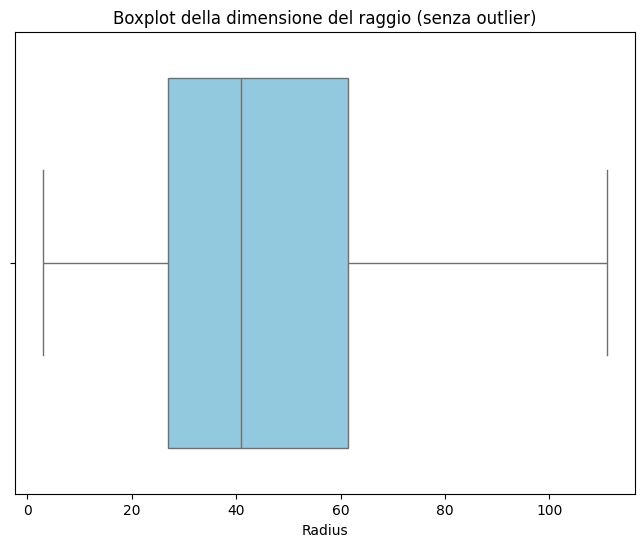

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assicurati che Radius sia numerico
df['Radius'] = pd.to_numeric(df['Radius'], errors='coerce')

plt.figure(figsize=(8,6))
sns.boxplot(x=df['Radius'], showfliers=False, color='skyblue')
plt.title('Boxplot della dimensione del raggio (senza outlier)')
plt.xlabel('Radius')
plt.show()


## 1.3 TECNICHE PER EVIDENZIARE LE ANOMALIE

Da come abbiamo potuto vedere, alcune anomalie se prendiamo l'immagine così com'è non sono visibili, nonostante il seno non sia troppo denso. Applichiamo una serie di tecniche per migliorare la visualizzazione 

### 1.3.1 CLAHE

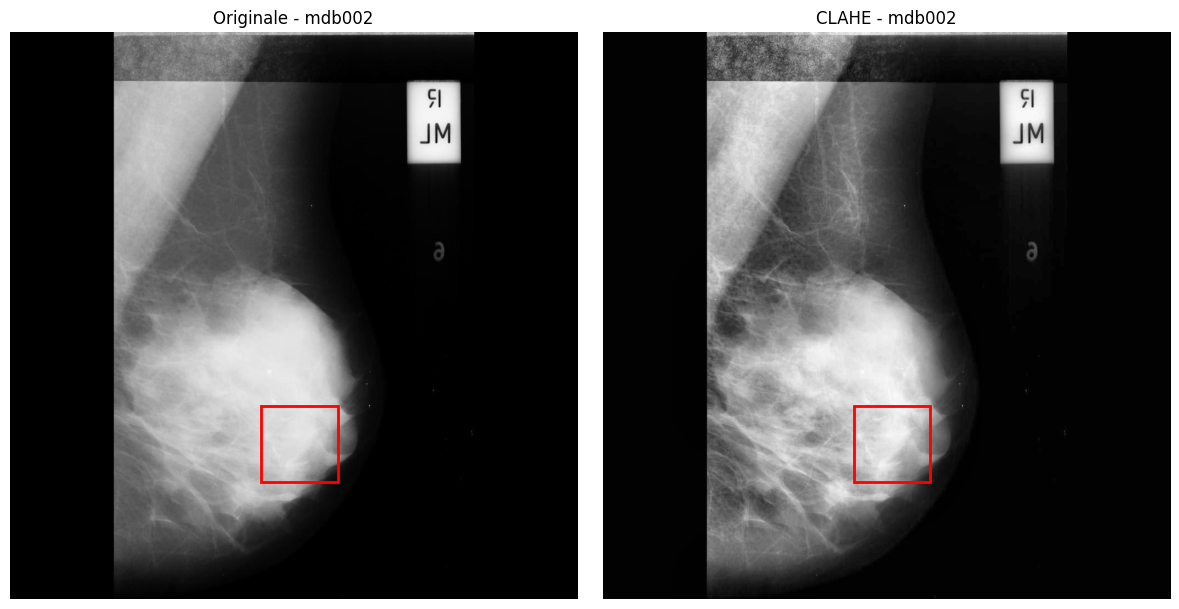

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image
import cv2
import numpy as np

# === Parametri ===
image_id = 'mdb002'  # <-- Inserisci qui il nome dell'immagine da visualizzare (senza estensione)
csv_path = 'mammography_dataset.csv'
images_dir = 'MIAS-JPEG'  # <-- Cambia con il tuo path corretto

# === Carica CSV ===
df = pd.read_csv(csv_path)

# Conversione colonne
df['X_Center'] = pd.to_numeric(df['X_Center'], errors='coerce')
df['Y_Center'] = pd.to_numeric(df['Y_Center'], errors='coerce')
df['Radius'] = pd.to_numeric(df['Radius'], errors='coerce')

# Filtro solo riga corrispondente all'immagine richiesta
row = df[df['Image_ID'].str.lower() == image_id.lower()]
if row.empty:
    raise ValueError(f"Nessuna voce trovata per Image_ID = {image_id}")

row = row.iloc[0]

# === Caricamento immagine ===
img_path = os.path.join(images_dir, row['Image_ID'] + '.jpg')
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Immagine non trovata: {img_path}")

img_pil = Image.open(img_path).convert("L")
img_np = np.array(img_pil)

# === CLAHE ===
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(img_np)

# === Bounding Box ===
x_center = float(row['X_Center'])
y_center = float(row['Y_Center'])
r = float(row['Radius'])

# Converti y da origine bottom-left a top-left
y_top_left = img_np.shape[0] - y_center
x_min = x_center - r
y_min = y_top_left - r

# === Plot ===
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, image, title in zip(
    axes,
    [img_np, clahe_img],
    ['Originale', 'CLAHE']
):
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{title} - {row["Image_ID"]}')
    ax.axis('off')

    rect = patches.Rectangle(
        (x_min, y_min), 2*r, 2*r,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.show()


### 1.3.2 Pipeline

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# === Funzioni di image enhancement ===
def manual_windowing(img, low_pct=5, high_pct=95):
    """Windowing percentile-based."""
    low, high = np.percentile(img, (low_pct, high_pct))
    return np.clip((img - low) * 255.0 / (high - low), 0, 255).astype(np.uint8)

def clahe_enhancement(img, clip=2.0, grid=(8,8)):
    """CLAHE enhancement."""
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=grid)
    return clahe.apply(img)

def unsharp_mask(img, kernel_size=(5,5), sigma=1.0, strength=1.5):
    """Unsharp Mask sharpening."""
    blur = cv2.GaussianBlur(img, kernel_size, sigma)
    mask = cv2.subtract(img, blur)
    return cv2.add(img, (mask * strength).astype(np.uint8))

# === Pipeline completa ===
def enhancement_pipeline(img):
    win = manual_windowing(img)
    clahe_img = clahe_enhancement(win)
    sharp_img = unsharp_mask(clahe_img)
    return win, clahe_img, sharp_img

# === Caricamento dati CSV ===
image_id = 'mdb058'
csv_path = 'mammography_dataset.csv'
images_dir = 'MIAS-JPEG'

df = pd.read_csv(csv_path)
df['X_Center'] = pd.to_numeric(df['X_Center'], errors='coerce')
df['Y_Center'] = pd.to_numeric(df['Y_Center'], errors='coerce')
df['Radius'] = pd.to_numeric(df['Radius'], errors='coerce')

row = df[df['Image_ID'].str.lower() == image_id.lower()].iloc[0]

x_center, y_center, r = float(row['X_Center']), float(row['Y_Center']), float(row['Radius'])

# === Caricamento immagine ===
img_path = os.path.join(images_dir, row['Image_ID'] + '.jpg')
img_pil = Image.open(img_path).convert("L")
img_np = np.array(img_pil)

# === Coordinate bounding box ===
y_top_left = img_np.shape[0] - y_center
x_min, y_min = x_center - r, y_top_left - r

# === Applica pipeline ===
win, clahe_img, enhanced_img = enhancement_pipeline(img_np)

# === Visualizzazione ===
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle(f'Enhancement + Bounding Box - {image_id}', fontsize=16, fontweight='bold')

titles = ['Originale', 'Windowing', 'CLAHE', 'Finale (Unsharp)']
images = [img_np, win, clahe_img, enhanced_img]

for ax, title, im in zip(axes, titles, images):
    ax.imshow(im, cmap='gray')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # Draw bounding box
    rect = patches.Rectangle((x_min, y_min), 2*r, 2*r,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.tight_layout()
plt.savefig(f'enhanced_bbox_{image_id}.png', dpi=300, bbox_inches='tight')
plt.show()



Errore: Il file 'object_detection.csv' o la cartella 'imagesROI' non sono stati trovati.
Assicurati che il file CSV e la cartella delle immagini si trovino nella stessa directory in cui esegui lo script.


 ## 2 Determinazione del peso e dell'età delle donne

### plot per le diverse densità dei seni

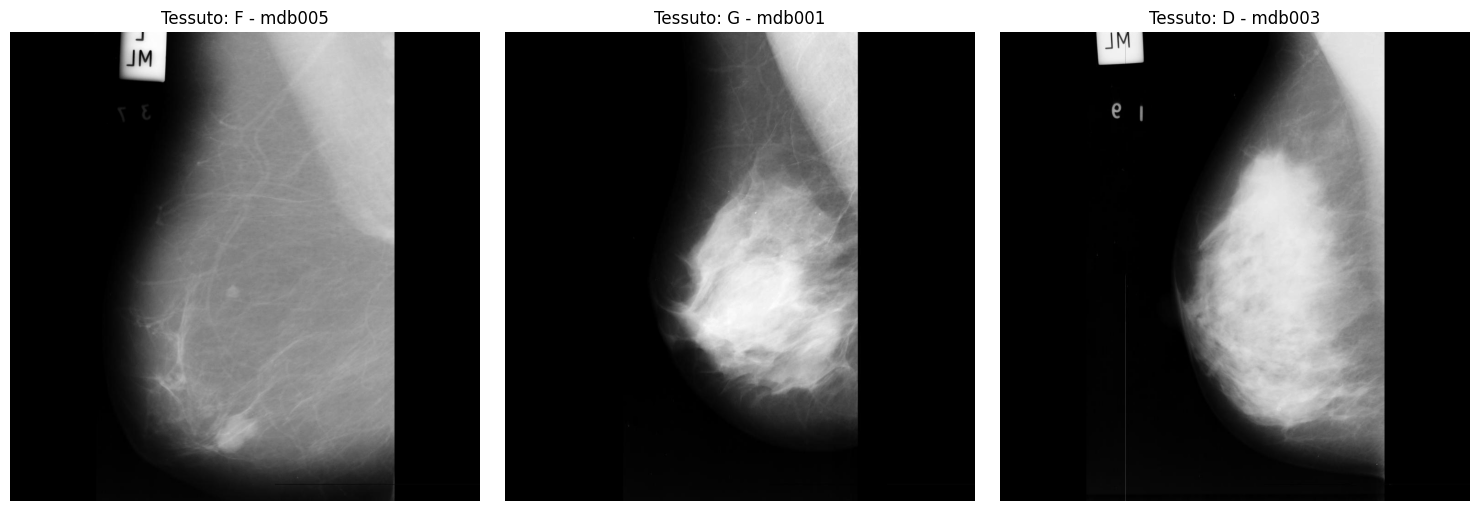

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Percorsi
csv_path = 'dataset/mammography_dataset.csv'
images_dir = 'dataset/images'

# Carica il CSV
df = pd.read_csv(csv_path)

# Seleziona un'immagine per ciascun tipo di tessuto: F, G, D
selected_tissues = ['F', 'G', 'D']
samples = []

for tissue in selected_tissues:
    sample = df[df['Breast_Tissue'] == tissue].head(1)
    if not sample.empty:
        samples.append(sample.iloc[0])

# Plot delle immagini
fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))

for ax, row in zip(axes, samples):
    image_id = row['Image_ID']
    image_path = os.path.join(images_dir, image_id + '.jpg')  # cambia estensione se serve

    if os.path.exists(image_path):
        image = Image.open(image_path).convert('L')  # converte in scala di grigi
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Tessuto: {row['Breast_Tissue']} - {image_id}")
        ax.axis('off')
    else:
        ax.set_title(f"{image_id} non trovato")
        ax.axis('off')

plt.tight_layout()
plt.show()



### 2.1 Plot seni densi

Trovati 117 seni densi (Tipo D) nel dataset.


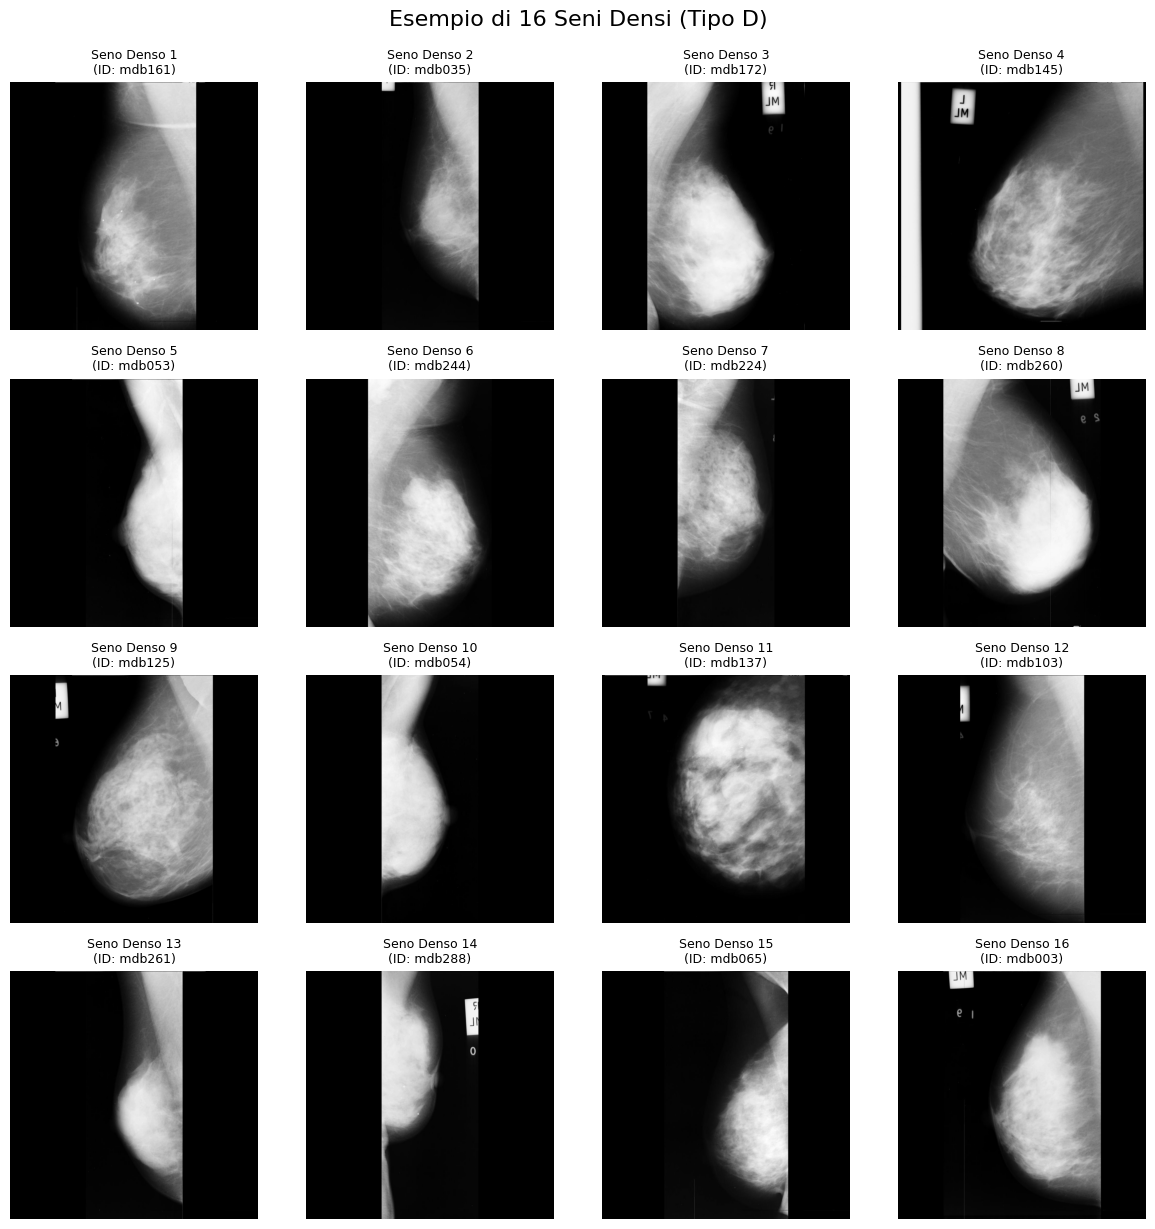

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os # Necessario per costruire i percorsi dei file
from PIL import Image # Per PNG, JPG, ecc. (pip install Pillow)

# Esempio per immagini PNG/JPG:
IMAGE_DIRECTORY = 'MIAS-JPEG' # <

def load_image_from_id(image_id):
    """
    Carica un'immagine dal disco dato il suo ID.
    Questa è una funzione placeholder; devi modificarla per adattarla al tuo setup.
    """
    # Esempio per file PNG/JPG:
    image_path = os.path.join(IMAGE_DIRECTORY, f"{image_id}.jpg") # O .jpg, .jpeg, ecc.
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Immagine non trovata: {image_path}. Verifica il percorso e l'ID.")
    img = Image.open(image_path).convert('L') # Carica come immagine in scala di grigi ('L' per Luminance)
    return np.array(img) # Converte l'immagine PIL in un array NumPy

# Assicurati che 'Breast_Tissue' sia di tipo categorico per un ordinamento corretto
df['Breast_Tissue'] = pd.Categorical(df['Breast_Tissue'], categories=['F', 'G', 'D'], ordered=True)

# --- Filtra e Seleziona Seni Densi (Tipo 'D') ---
# Estrai solo le righe dove il tipo di tessuto è 'D'
dense_breasts_df = df[df['Breast_Tissue'] == 'D']

print(f"Trovati {len(dense_breasts_df)} seni densi (Tipo D) nel dataset.")

# Seleziona fino a 16 ID di immagini di seni densi
num_to_plot = min(16, len(dense_breasts_df))

if num_to_plot == 0:
    print("Nessun seno denso (Tipo D) disponibile nel dataset per il plottaggio.")
else:
    # Prendi un campione casuale di Image_ID se ce ne sono più di quelli che vogliamo plottare
    # Usa random_state per rendere la selezione riproducibile
    image_ids_to_plot = dense_breasts_df['Image_ID'].sample(n=num_to_plot, random_state=42).tolist()

    # --- Prepara la Griglia per il Plottaggio ---
    rows = int(np.ceil(np.sqrt(num_to_plot)))
    cols = int(np.ceil(num_to_plot / rows))

    plt.figure(figsize=(cols * 3, rows * 3)) # Imposta le dimensioni della figura

    for i, image_id in enumerate(image_ids_to_plot):
        try:
            # Carica l'array di pixel dell'immagine usando l'ID
            img_array = load_image_from_id(image_id)

            plt.subplot(rows, cols, i + 1)
            plt.imshow(img_array, cmap='gray') # Mostra l'immagine in scala di grigi
            plt.title(f"Seno Denso {i+1}\n(ID: {image_id})", fontsize=9) # Aggiungi l'ID al titolo
            plt.axis('off') # Rimuovi gli assi per un'immagine più pulita
        except FileNotFoundError as e:
            print(f"Errore caricamento immagine {image_id}: {e}. Salto questa immagine.")
            # Puoi plottare un placeholder vuoto o lasciare lo spazio vuoto
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, 'Immagine non trovata', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')
            plt.axis('off')
        except Exception as e:
            print(f"Errore generico caricamento immagine {image_id}: {e}. Salto questa immagine.")
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, 'Errore caricamento', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')
            plt.axis('off')


    plt.tight_layout() # Adatta i subplot per evitare sovrapposizioni
    plt.suptitle(f"Esempio di {num_to_plot} Seni Densi (Tipo D)", y=1.02, fontsize=16)
    plt.show()

### 2.2 Plot seni per età

Trovate 63 età uniche nel dataset.


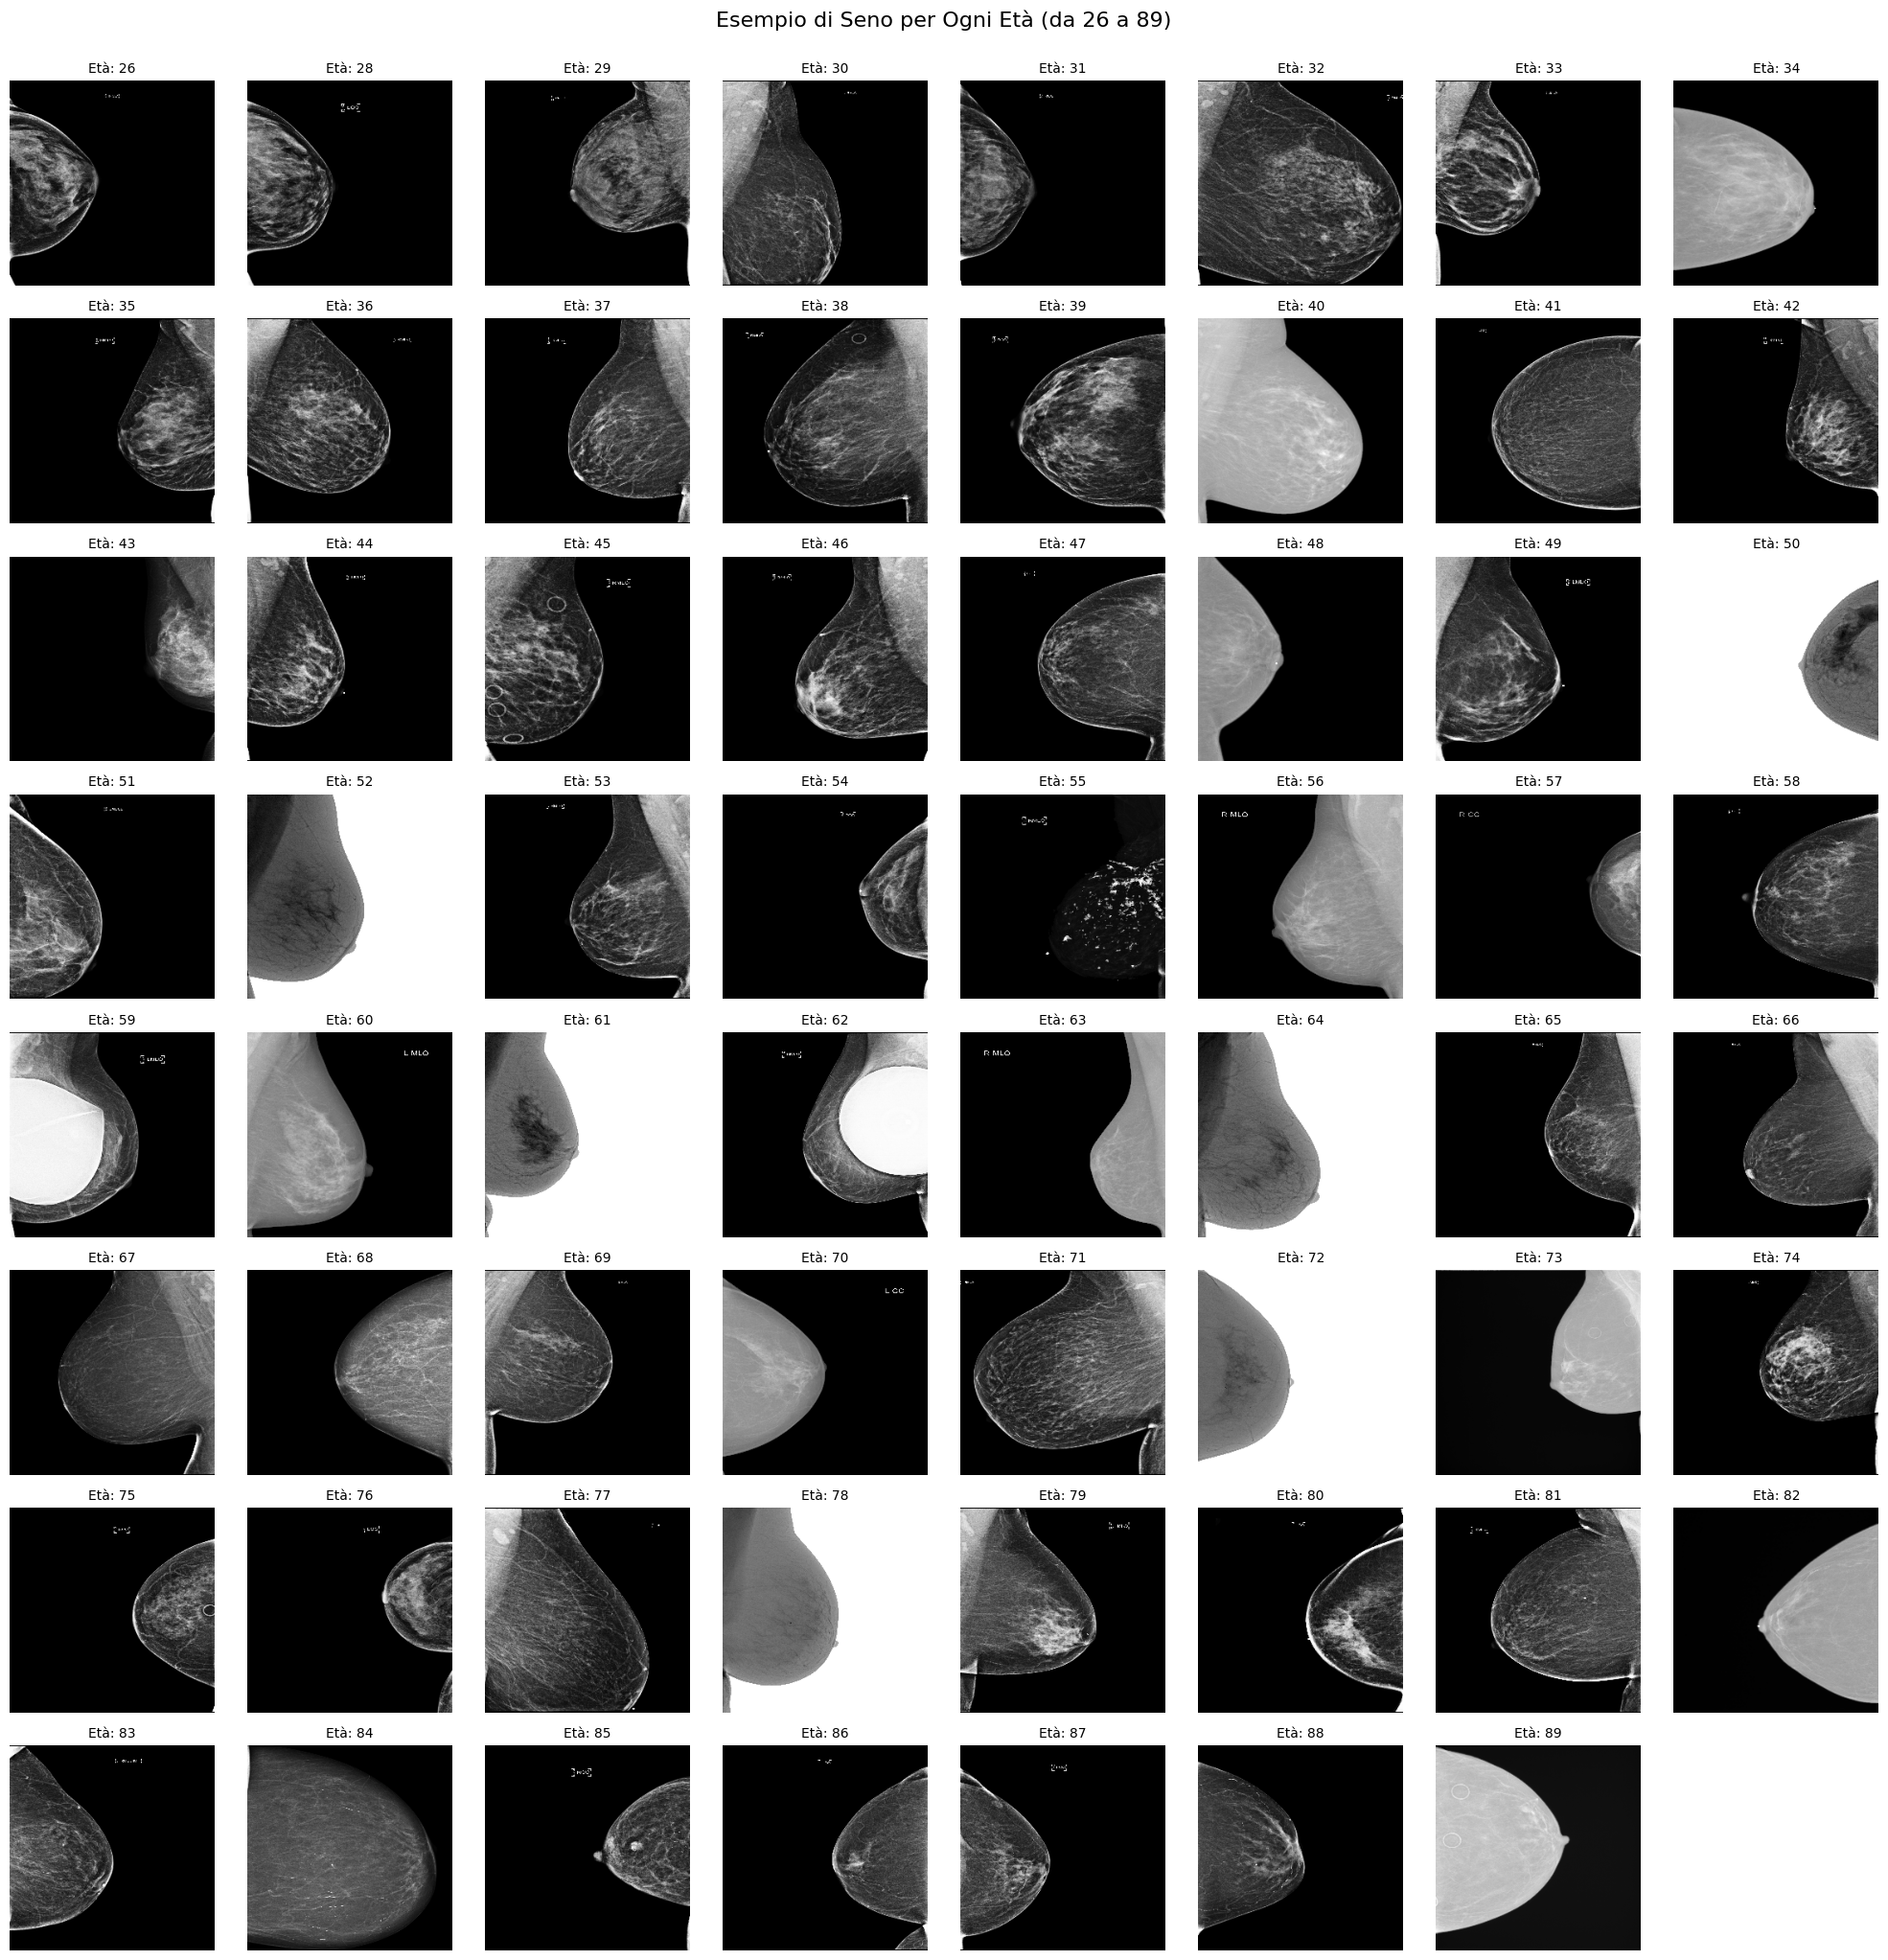

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image # Per caricare immagini .png, .jpg, ecc.
# import pydicom # Decommenta se le tue immagini sono file DICOM (.dcm)

# --- CONFIGURAZIONE ---
# 1. PERCORSO DEL TUO FILE CSV/TSV CON I METADATI
METADATA_FILE = r'C:\Users\smike18\.cache\kagglehub\datasets\gauravduttakiit\mammography-breast-cancer-detection\versions\2\train.csv' 

# 2. PERCORSO DELLA CARTELLA BASE CHE CONTIENE 'train' e 'test'
# NON includere 'train\' o 'test\' qui, li aggiungeremo dinamicamente.
BASE_DATASET_FOLDER = r'C:\Users\smike18\.cache\kagglehub\datasets\gauravduttakiit\mammography-breast-cancer-detection\versions\2' # <--- MODIFICA SE NECESSARIO

# 3. ESTENSIONE DEI FILE IMMAGINE
IMAGE_EXTENSION = '.png' # <--- MODIFICA QUESTO SE I TUOI FILE SONO .dcm, .jpg, ecc.

# --- FUNZIONE PER CARICARE L'IMMAGINE (MODIFICATA PER GESTIRE DIVERSE SOTTOCARTELLE) ---
def load_mammography_image(patient_id, image_id, cancer_status):
    """
    Carica un'immagine mammografica dal disco.
    La funzione costruisce il percorso basandosi sullo stato 'cancer' (0 o 1).
    """
    # Assumiamo che stiamo lavorando con il set 'train'
    split_folder = 'train' 
    
    # La sottocartella per lo stato del cancro (0 o 1)
    cancer_subfolder = str(cancer_status) 
    
    image_filename = f"{patient_id}_{image_id}{IMAGE_EXTENSION}"
    
    # Costruisce il percorso completo: BASE_DATASET_FOLDER / split_folder / cancer_subfolder / image_filename
    image_path = os.path.join(BASE_DATASET_FOLDER, split_folder, cancer_subfolder, image_filename)

    if not os.path.exists(image_path):
        # Se l'immagine non viene trovata nel percorso atteso, prova a darne un messaggio più specifico.
        # Oppure potresti qui implementare una logica di ricerca alternativa
        # Se sai che a volte sono direttamente sotto 'train' senza 0/1:
        # image_path_alt = os.path.join(BASE_DATASET_FOLDER, split_folder, image_filename)
        # if os.path.exists(image_path_alt):
        #    image_path = image_path_alt
        # else:
            raise FileNotFoundError(f"Immagine non trovata nel percorso atteso: {image_path}")

    if IMAGE_EXTENSION.lower() in ['.png', '.jpg', '.jpeg']:
        img = Image.open(image_path).convert('L') # Carica come scala di grigi
        return np.array(img)
    # elif IMAGE_EXTENSION.lower() == '.dcm':
    #     # Decommenta e adatta per i file DICOM
    #     # ds = pydicom.dcmread(image_path)
    #     # img_data = ds.pixel_array
    #     # return img_data
    else:
        raise ValueError(f"Estensione immagine non supportata o non implementata: {IMAGE_EXTENSION}")

# --- Carica il dataset dei metadati ---
try:
    df = pd.read_csv(METADATA_FILE) 
except FileNotFoundError:
    print(f"Errore: Il file dei metadati '{METADATA_FILE}' non è stato trovato.")
    print("Assicurati che il percorso e il nome del file siano corretti.")
    exit()

# Assicurati che le colonne chiave siano presenti (aggiungiamo 'cancer' qui)
required_cols = ['patient_id', 'image_id', 'age', 'cancer'] 
if not all(col in df.columns for col in required_cols):
    print(f"Errore: Il DataFrame non contiene tutte le colonne richieste: {required_cols}")
    print("Controlla il nome delle colonne nel tuo file di metadati.")
    exit()

# Rimuovi righe con età mancante se necessario
df = df.dropna(subset=['age', 'cancer']).copy() # Rimuovi anche se 'cancer' è mancante
df['age'] = df['age'].astype(int) 
df['cancer'] = df['cancer'].astype(int) # Assicurati che 'cancer' sia int per usarlo come nome cartella

# Ordina il DataFrame per età e poi rimuovi i duplicati per età, prendendo la prima occorrenza
# (che potrebbe essere cancer=0 o cancer=1 a seconda dell'ordine originale nel df)
df_sorted_by_age = df.sort_values(by='age').drop_duplicates(subset=['age'])

print(f"Trovate {len(df_sorted_by_age)} età uniche nel dataset.")

# --- Prepara il plottaggio ---
ages_to_plot = df_sorted_by_age['age'].tolist()
num_images = len(ages_to_plot)

if num_images == 0:
    print("Nessuna età valida trovata per il plottaggio.")
else:
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))

    plt.figure(figsize=(cols * 2.5, rows * 2.5)) 

    for i, age_val in enumerate(ages_to_plot):
        row_data = df_sorted_by_age[df_sorted_by_age['age'] == age_val].iloc[0]
        patient_id = row_data['patient_id']
        image_id = row_data['image_id']
        cancer_status = row_data['cancer'] # Recupera lo stato 'cancer' dalla riga

        try:
            # Passa il cancer_status alla funzione di caricamento
            img_array = load_mammography_image(patient_id, image_id, cancer_status)

            plt.subplot(rows, cols, i + 1)
            plt.imshow(img_array, cmap='gray')
            plt.title(f"Età: {age_val}", fontsize=10)
            plt.axis('off')
        except FileNotFoundError as e:
            print(f"Avviso: {e}. Salto l'immagine per età {age_val} (P_ID: {patient_id}, I_ID: {image_id}, Cancer: {cancer_status}).")
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, f"Immagine non trovata\nEtà: {age_val}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red', fontsize=9)
            plt.axis('off')
        except Exception as e:
            print(f"Errore generico caricando immagine per età {age_val} (P_ID: {patient_id}, I_ID: {image_id}, Cancer: {cancer_status}): {e}. Salto.")
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, f"Errore caricamento\nEtà: {age_val}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red', fontsize=9)
            plt.axis('off')

    plt.tight_layout()
    plt.suptitle(f"Esempio di Seno per Ogni Età (da {df['age'].min()} a {df['age'].max()})", y=1.02, fontsize=16)
    plt.show()

### 2.3 Correlazioni tra i dati del dataset più ampio

Correlazione tra variabili numeriche:
             age    cancer
age     1.000000  0.075155
cancer  0.075155  1.000000


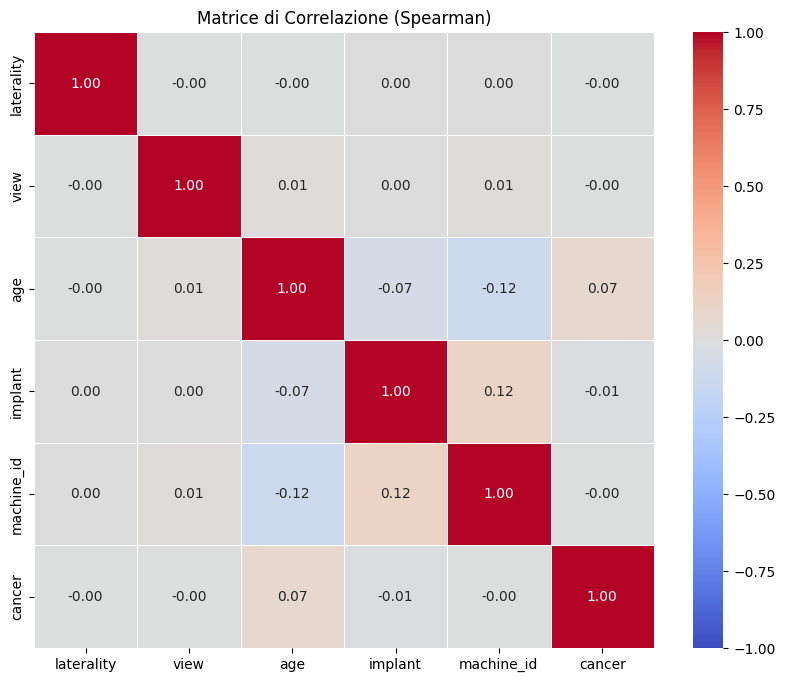


Correlazione con la variabile 'cancer':
cancer        1.000000
age           0.073799
view         -0.000412
machine_id   -0.000640
laterality   -0.002748
implant      -0.014311
Name: cancer, dtype: float64


In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Carica il dataset
df = pd.read_csv('train.csv')

# Seleziona solo le colonne rilevanti per l'analisi (escludi gli ID)
analysis_cols = ['laterality', 'view', 'age', 'implant', 'machine_id', 'cancer']
df_analysis = df[analysis_cols].copy()

# 1. Analisi correlazioni variabili numeriche
print("Correlazione tra variabili numeriche:")
print(df_analysis[['age', 'cancer']].corr())

# 2. Preparazione dati per correlazioni miste
# Codifica le variabili categoriche
le = LabelEncoder()
categorical_cols = ['laterality', 'view', 'machine_id']

for col in categorical_cols:
    df_analysis[col] = le.fit_transform(df_analysis[col])

# 3. Matrice di correlazione completa (metodo Spearman)
corr_matrix = df_analysis.corr(method='spearman')

# Visualizza la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    linewidths=0.5
)
plt.title('Matrice di Correlazione (Spearman)')
plt.show()

# 4. Analizza la correlazione con la variabile target 'cancer'
print("\nCorrelazione con la variabile 'cancer':")
cancer_corr = corr_matrix['cancer'].sort_values(ascending=False)
print(cancer_corr)

### 2.4 Correlazione dataset nostro

File 'mammography_dataset.csv' caricato con successo.

DataFrame Originale (prime 5 righe):
  Image_ID Breast_Tissue Anomaly_Type Severity X_Center Y_Center  Radius
0   mdb001             G         CIRC        B      535      425   197.0
1   mdb002             G         CIRC        B      522      280    69.0
2   mdb003             D         NORM      NaN      NaN      NaN     NaN
3   mdb004             D         NORM      NaN      NaN      NaN     NaN
4   mdb005             F         CIRC        B      500      168    26.0
--------------------------------------------------

Rimozione righe incomplete: Rimosse 211 righe con NaN nelle colonne chiave.
DataFrame pulito ha 119 righe.
--------------------------------------------------

DataFrame Pulito (prime 5 righe e colonne rilevanti):
    X_Center  Y_Center  Radius  Severity_B  Severity_M  Breast_Tissue_D  \
0      535.0     425.0   197.0        True       False            False   
1      522.0     280.0    69.0        True       False 

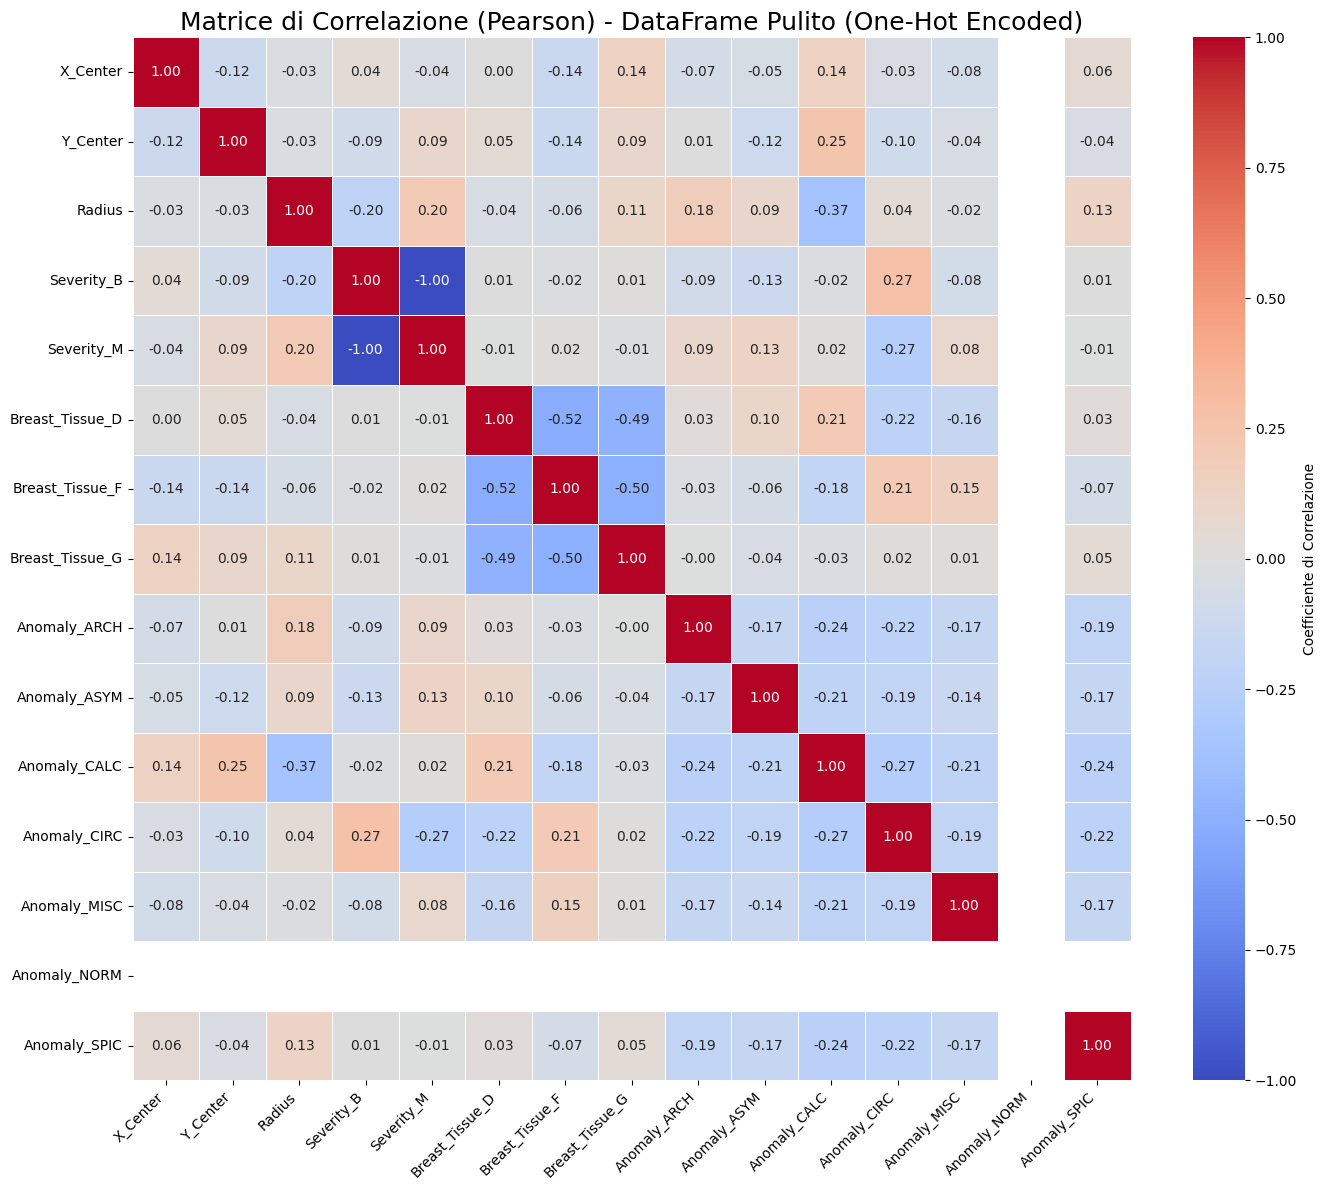

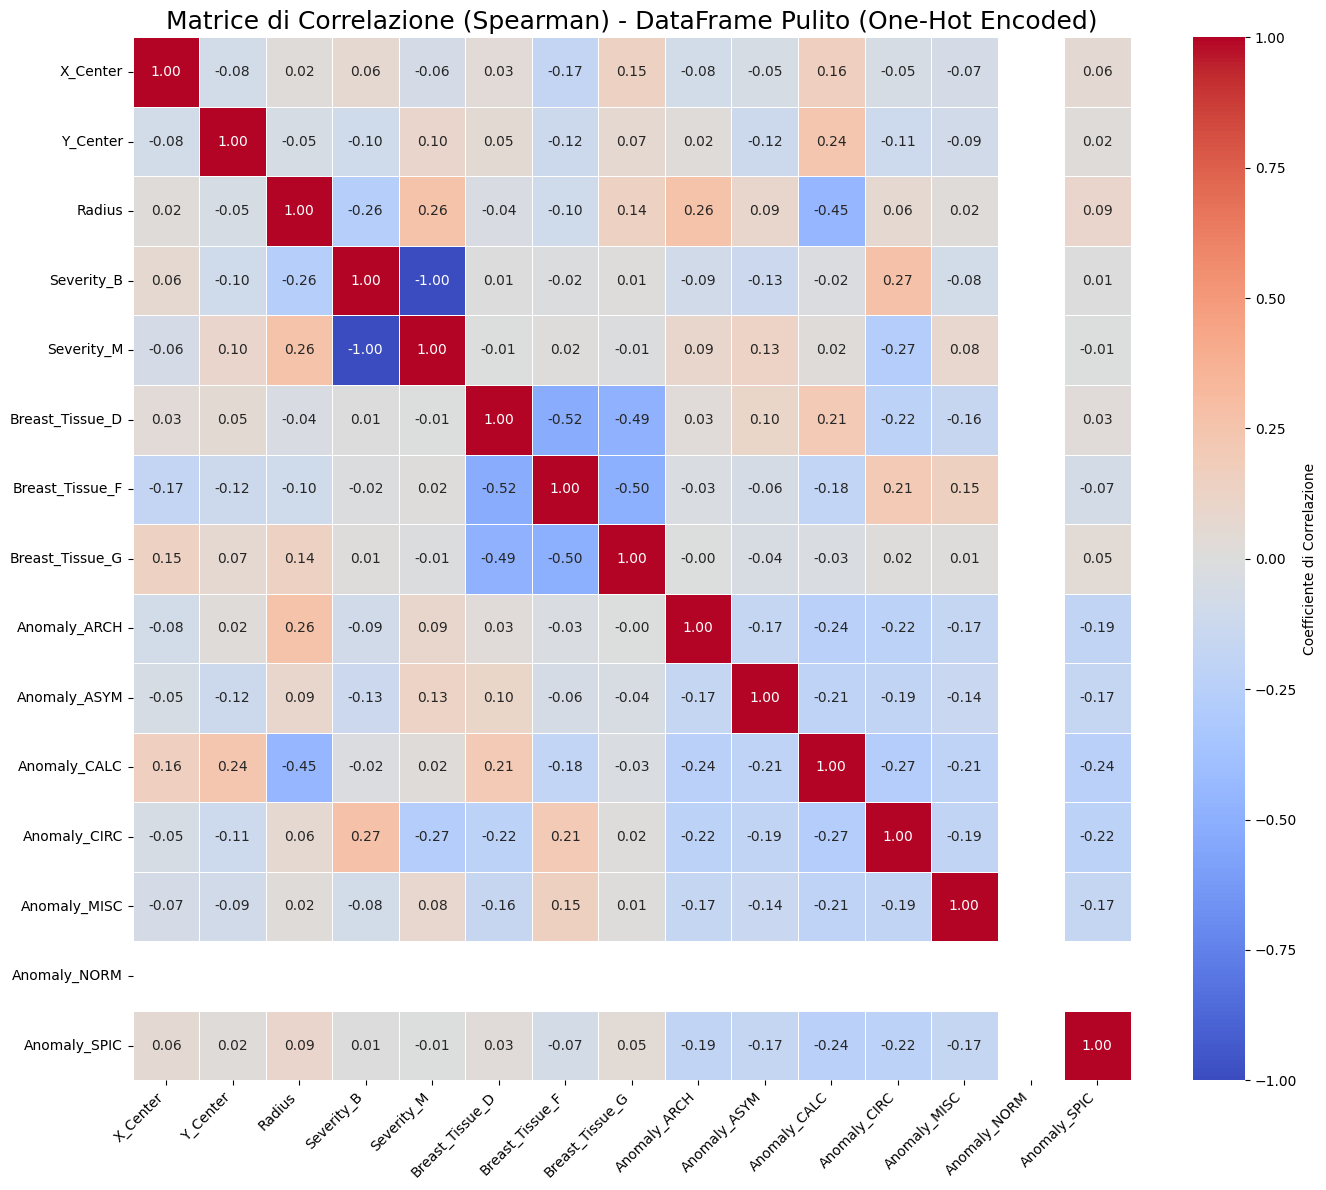


Script completato. Le heatmap delle matrici di correlazione sono state generate per il DataFrame pulito con One-Hot Encoding su tutte le variabili categoriali.


In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- CONFIGURAZIONE INIZIALE ---
# Percorso del tuo file CSV con i metadati
try:
    df_original = pd.read_csv('mammography_dataset.csv')
    print("File 'mammography_dataset.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file 'mammography_dataset.csv' non è stato trovato.")
    print("Assicurati che il file sia nella stessa directory dello script, o fornisci il percorso completo.")
    exit()

print("\nDataFrame Originale (prime 5 righe):")
print(df_original.head())
print("-" * 50)

# --- Pre-processing del DataFrame ---

df_processed = df_original.copy()

# 1. Gestisci valori non numerici in X_Center, Y_Center, Radius PRIMA del One-Hot Encoding
#    Questo assicura che pd.get_dummies non cerchi di elaborare stringhe non numeriche
df_processed['X_Center'] = pd.to_numeric(df_processed['X_Center'], errors='coerce')
df_processed['Y_Center'] = pd.to_numeric(df_processed['Y_Center'], errors='coerce')
df_processed['Radius'] = pd.to_numeric(df_processed['Radius'], errors='coerce')

# 2. Applica One-Hot Encoding a 'Severity'
#    Questo creerà colonne come 'Severity_B' e 'Severity_M'.
#    Per le righe 'NORM' dove 'Severity' era NaN, le nuove colonne saranno NaN.
df_processed = pd.get_dummies(df_processed, columns=['Severity'], prefix='Severity')

# 3. Applica One-Hot Encoding a 'Breast_Tissue'
#    Questo creerà colonne come 'Breast_Tissue_F', 'Breast_Tissue_G', 'Breast_Tissue_D'.
df_processed = pd.get_dummies(df_processed, columns=['Breast_Tissue'], prefix='Breast_Tissue')

# 4. Applica One-Hot Encoding a 'Anomaly_Type'
df_processed = pd.get_dummies(df_processed, columns=['Anomaly_Type'], prefix='Anomaly')

# --- DEFINIZIONE DELLE COLONNE CHIAVE PER LA COMPLETEZZA ---
# Definisci le colonne che devono essere complete.
# Qui includiamo le nuove colonne One-Hot di Severity e Breast_Tissue,
# oltre alle coordinate e al raggio.
key_columns_for_completeness = [
    'X_Center',
    'Y_Center',
    'Radius'
]

# Aggiungi dinamicamente le colonne One-Hot generate per Severity, Breast_Tissue, Anomaly_Type
# È importante che queste colonne esistano prima di aggiungerle alla lista.
# Generalizziamo il loop per includere tutte le colonne One-Hot desiderate.
for col_prefix in ['Severity', 'Breast_Tissue', 'Anomaly']:
    for col in df_processed.columns:
        if col.startswith(col_prefix + '_') and col not in key_columns_for_completeness:
            key_columns_for_completeness.append(col)

# Filtra solo le colonne che effettivamente esistono nel DataFrame per evitare errori
key_columns_for_completeness = [col for col in key_columns_for_completeness if col in df_processed.columns]


# --- RIMUOVE LE RIGHE CON VALORI MANCANTI NELLE COLONNE CHIAVE ---
# Vengono rimosse tutte le righe che hanno almeno un NaN nelle 'key_columns_for_completeness'.
# Questo include le righe 'NORM' (che avranno NaN in X, Y, Radius e nelle colonne Severity_X)
# e le righe con dati problematici come '*NOTE' che sono stati convertiti in NaN.
initial_rows = df_processed.shape[0]
df_cleaned = df_processed.dropna(subset=key_columns_for_completeness)
rows_removed = initial_rows - df_cleaned.shape[0]

print(f"\nRimozione righe incomplete: Rimosse {rows_removed} righe con NaN nelle colonne chiave.")
print(f"DataFrame pulito ha {df_cleaned.shape[0]} righe.")
print("-" * 50)


print("\nDataFrame Pulito (prime 5 righe e colonne rilevanti):")
# Stampa le prime righe del DataFrame pulito, usando le colonne definite per la correlazione
print(df_cleaned[key_columns_for_completeness].head())
print("-" * 50)


# --- Seleziona le colonne per il calcolo della correlazione ---
# Ora usiamo le stesse colonne che abbiamo considerato "chiave" per la pulizia
cols_for_correlation = key_columns_for_completeness


# --- Calcolo della Matrice di Correlazione (Pearson) ---
correlation_matrix_pearson = df_cleaned[cols_for_correlation].corr(method='pearson')

print("\nMatrice di Correlazione (Pearson) - DataFrame Pulito (One-Hot Encoded):")
print(correlation_matrix_pearson.round(2))
print("-" * 50)

# --- Calcolo della Matrice di Correlazione (Spearman) ---
# Anche se One-Hot è più spesso usato con Pearson, Spearman può comunque essere calcolato.
correlation_matrix_spearman = df_cleaned[cols_for_correlation].corr(method='spearman')

print("\nMatrice di Correlazione (Spearman) - DataFrame Pulito (One-Hot Encoded):")
print(correlation_matrix_spearman.round(2))
print("-" * 50)


# --- Visualizzazione (Heatmap) per Pearson ---
plt.figure(figsize=(14, 12)) # Aumenta la dimensione per più colonne
sns.heatmap(correlation_matrix_pearson, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Coefficiente di Correlazione'})
plt.title('Matrice di Correlazione (Pearson) - DataFrame Pulito (One-Hot Encoded)', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Visualizzazione (Heatmap) per Spearman ---
plt.figure(figsize=(14, 12)) # Aumenta la dimensione per più colonne
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Coefficiente di Correlazione'})
plt.title('Matrice di Correlazione (Spearman) - DataFrame Pulito (One-Hot Encoded)', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nScript completato. Le heatmap delle matrici di correlazione sono state generate per il DataFrame pulito con One-Hot Encoding su tutte le variabili categoriali.")

## Correlazioni Principali (|r| > 0.25)

### 1. **Radius vs Anomaly_CALC**  
📌 **Coefficiente**: -0.37  
🔍 **Interpretazione**:  
- Lesioni con raggio maggiore tendono ad avere meno calcificazioni  
- Possibile relazione inversa tra dimensione della lesione e presenza di CALC  

### 2. **Y_Center vs Anomaly_CALC**  
📌 **Coefficiente**: 0.25  
🔍 **Interpretazione**:  
- Lesioni posizionate più in alto (valori Y maggiori) mostrano maggiore associazione con calcificazioni  
- La posizione verticale potrebbe essere un marker per CALC  

### 3. **Severity_B vs Anomaly_CHRC**  
📌 **Coefficiente**: 0.27  
🔍 **Interpretazione**:  
- Forte associazione tra lesioni benigne e anomalie circolari/irregolari (CHRC)  
- CHRC potrebbe essere un indicatore di benignità  

### 4. **Severity_M vs Anomaly_CHRC**  
📌 **Coefficiente**: -0.27  
🔍 **Interpretazione**:  
- Relazione inversa tra malignità e anomalie CHRC  
- Conferma che CHRC è più frequente in lesioni benigne  

## Correlazioni Secondarie (0.20 ≤ |r| < 0.25)

| Variabili                | Coefficiente | Relazione                          |
|--------------------------|--------------|------------------------------------|
| Radius vs Severity_M     | 0.20         | Lesioni più grandi ↔ malignità    |
| Breast_Tissue_F vs CHRC  | 0.21         | Tessuto adiposo ↔ anomalie CHRC   |
| Breast_Tissue_D vs CHRC  | -0.22        | Tessuto denso ↔ meno CHRC         |

## Key Insights 🧠

```python
["Anomaly_CALC", "Radius", "Y_Center"]  # Triade con correlazioni più forti
["Anomaly_CHRC", "Severity"]           # Forte relazione con benignità/malignità

### Download datasets online

In [81]:
pip install kagglehub

In [82]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gauravduttakiit/mammography-breast-cancer-detection")

print("Path to dataset files:", path)

100%|██████████| 0.98G/0.98G [08:16<00:00, 2.11MB/s]

Extracting files...


Path to dataset files: C:\Users\smike18\.cache\kagglehub\datasets\gauravduttakiit\mammography-breast-cancer-detection\versions\2
